## Packages and set-up

In [ ]:
!pip install datasets nltk textstat matplotlib seaborn readability-lxml spacy scikit-learn tqdm

import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import textstat
import spacy
from tqdm import tqdm
from datasets import load_dataset
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [ ]:
import os

In [ ]:
# update datasets
pip install -U datasets

In [ ]:
plos = load_dataset("BioLaySumm/BioLaySumm2025-PLOS", download_mode="force_redownload")
elife = load_dataset("BioLaySumm/BioLaySumm2025-eLife", download_mode="force_redownload")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/693 [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/169M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/170M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/169M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/28.2M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.19M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24773 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1376 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/142 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/689 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/126M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.92M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4346 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/142 [00:00<?, ? examples/s]

In [ ]:
# Convert to Pandas DataFrames
def dataset_to_df(ds_dict):
    return {split: ds_dict[split].to_pandas() for split in ds_dict}

plos_df = dataset_to_df(plos)
elife_df = dataset_to_df(elife)

Checkpoint summary of datasets

In [ ]:
# Checkpoint: print summary
print("PLOS Dataset Sizes:", {k: len(v) for k, v in plos_df.items()})
print("eLife Dataset Sizes:", {k: len(v) for k, v in elife_df.items()})
print("Columns Available:", plos_df['train'].columns.tolist())

PLOS Dataset Sizes: {'train': 24773, 'validation': 1376, 'test': 142}
eLife Dataset Sizes: {'train': 4346, 'validation': 241, 'test': 142}
Columns Available: ['article', 'summary', 'section_headings', 'keywords', 'year', 'title']


## Run these cells for toy version of datasets

In [ ]:
# would need to change calls to the datasets to be elife_small and plos_small

import random
plos_train_small = plos_df['train'].sample(n=1000, random_state=42).copy()
plos_val_small = plos_df['validation'].sample(n=50, random_state=42).copy()
plos_test_small = plos_df['test'].sample(n=50, random_state=42).copy()

# Combine into a dictionary similar to the original structure
plos_df_small = {
    'train': plos_train_small,
    'validation': plos_val_small,
    'test': plos_test_small
}

# Take 50 rows from each split and copy to avoid SettingWithCopyWarnings
elife_train_small = elife_df['train'].sample(n=1000, random_state=40).copy()
elife_val_small = elife_df['validation'].head(50).copy()
elife_test_small = elife_df['test'].head(50).copy()

# Combine into a dictionary like the original structure
elife_df_small = {
    'train': elife_train_small,
    'validation': elife_val_small,
    'test': elife_test_small
}

In [ ]:
print("PLOS SMALL Dataset Sizes:", {k: len(v) for k, v in plos_df_small.items()})
print("eLife SMALL Dataset Sizes:", {k: len(v) for k, v in elife_df_small.items()})
print("Columns Available:", plos_df_small['train'].columns.tolist())

PLOS SMALL Dataset Sizes: {'train': 1000, 'validation': 50, 'test': 50}
eLife SMALL Dataset Sizes: {'train': 1000, 'validation': 50, 'test': 50}
Columns Available: ['article', 'summary', 'section_headings', 'keywords', 'year', 'title']


In [ ]:
# def compute_length_features(df, text_col):
#     df[f"num_tokens_{text_col}"] = df[text_col].apply(lambda text: len(word_tokenize(text)))
#     df[f"num_sentences_{text_col}"] = df[text_col].apply(lambda text: len(sent_tokenize(text)))
#     return df

# # Apply only to train splits # SMALL
# plos_df_small['train'] = compute_length_features(plos_df_small['train'], "article")
# plos_df_small['train'] = compute_length_features(plos_df_small['train'], "summary")

# elife_df_small['train'] = compute_length_features(elife_df_small['train'], "article")
# elife_df_small['train'] = compute_length_features(elife_df_small['train'], "summary")



##Computing and visualizing length features for articles and summaries

Cell takes ~24 minutes for training splits in both full datasets

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize, sent_tokenize
from tqdm import tqdm

def compute_lengths(df):
    token_lens, sent_lens, summary_token_lens, summary_sent_lens = [], [], [], []

    for article, summary in tqdm(zip(df['article'], df['summary']), total=len(df)):
        tokens = word_tokenize(article)
        sents = sent_tokenize(article)
        summary_tokens = word_tokenize(summary)
        summary_sents = sent_tokenize(summary)

        token_lens.append(len(tokens))
        sent_lens.append(len(sents))
        summary_token_lens.append(len(summary_tokens))
        summary_sent_lens.append(len(summary_sents))

    df['num_tokens_article_len'] = token_lens
    df['num_sentences_article_len'] = sent_lens
    df['num_tokens_summary_len'] = summary_token_lens
    df['num_sentences_summary_len'] = summary_sent_lens
    return df
plos_df['train'] = compute_lengths(plos_df['train'])
elife_df['train'] = compute_lengths(elife_df['train'])


100%|██████████| 4346/4346 [05:29<00:00, 13.21it/s]


In [ ]:
def word_tokenize_text(text):
    return word_tokenize(text)

def sentence_tokenize_text(text):
    return sent_tokenize(text)

for df in [plos_df['train'], elife_df['train']]:  # Applying to 'train' split
    df['num_tokens_article'] = df['article'].apply(word_tokenize_text)
    df['num_sentences_article'] = df['article'].apply(sentence_tokenize_text)
    df['num_tokens_summary'] = df['summary'].apply(word_tokenize_text)
    df['num_sentences_summary'] = df['summary'].apply(sentence_tokenize_text)

       # Calculate the length of tokens and sentences
    df['num_tokens_article_len'] = df['num_tokens_article'].apply(len)
    df['num_sentences_article_len'] = df['num_sentences_article'].apply(len)
    df['num_tokens_summary_len'] = df['num_tokens_summary'].apply(len)
    df['num_sentences_summary_len'] = df['num_sentences_summary'].apply(len)

KeyboardInterrupt: 

Individual length plots for PLOS and eLife

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

save_folder = "/content/drive/MyDrive/plot_exports3"


Mounted at /content/drive


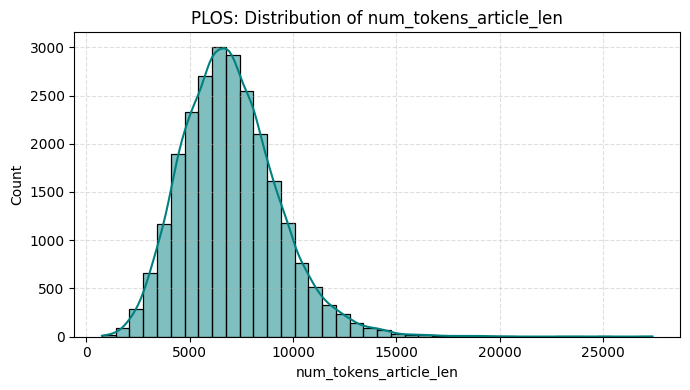

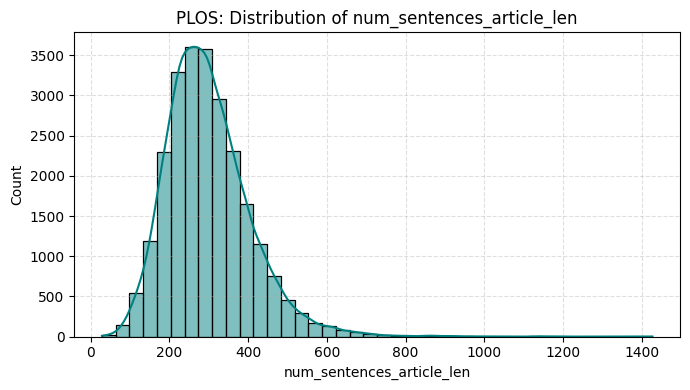

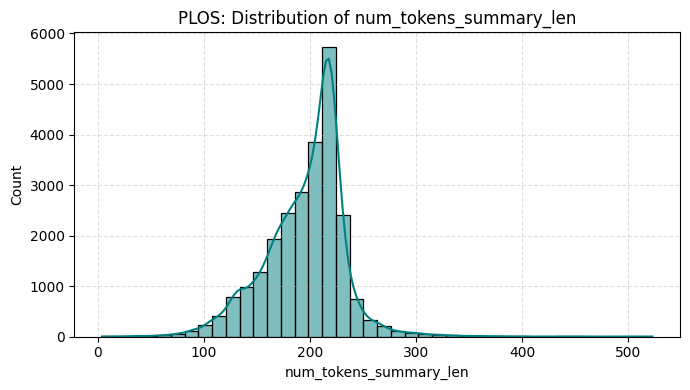

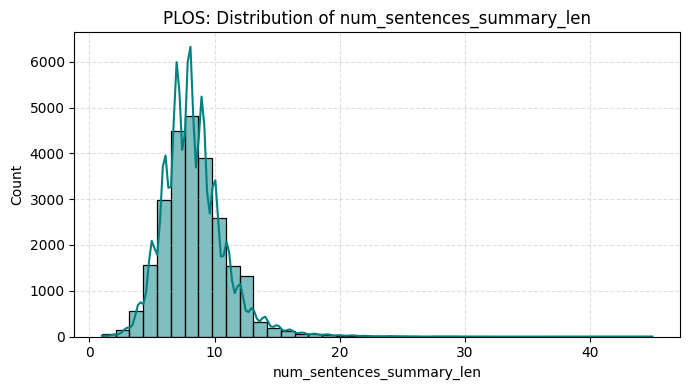

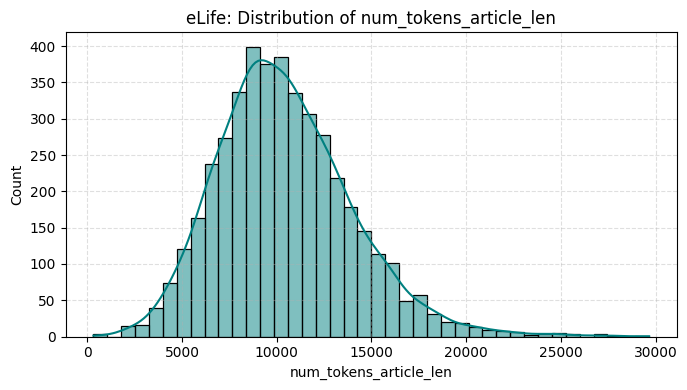

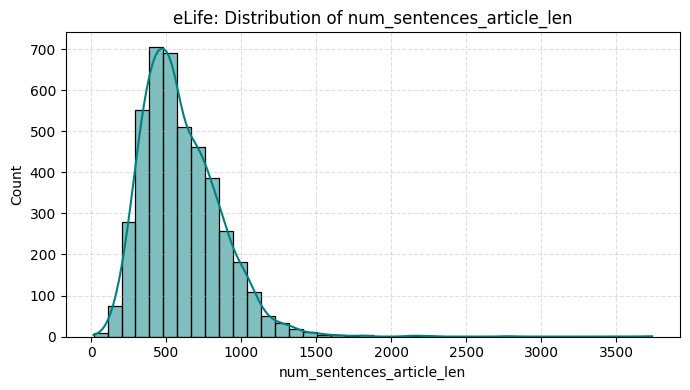

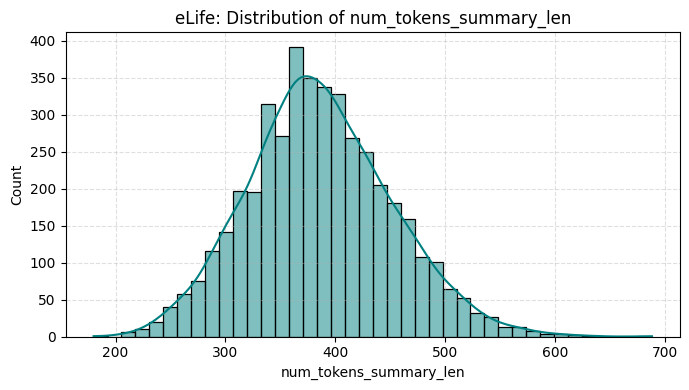

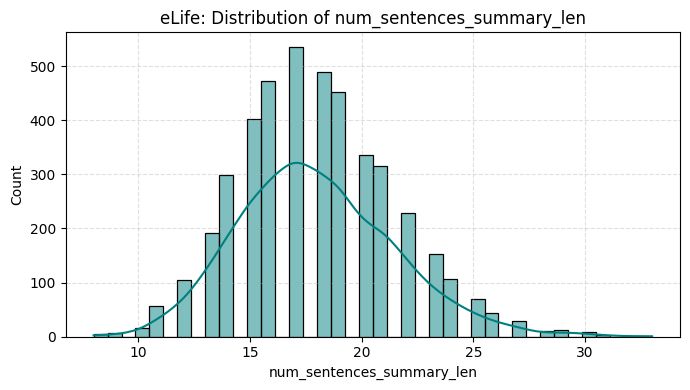

In [ ]:
import os
def plot_length_distributions(dataset, source_name, save_dir=None):
    features = [
        "num_tokens_article_len", "num_sentences_article_len",
        "num_tokens_summary_len", "num_sentences_summary_len",
    ]

    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for feat in features:
        plt.figure(figsize=(7, 4))
        sns.histplot(dataset[feat], bins=40, kde=True, color='teal')
        plt.title(f"{source_name}: Distribution of {feat}")
        plt.xlabel(feat)
        plt.ylabel("Count")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        if save_dir:
            filename = f"small_{source_name}_{feat}.png"
            filepath = os.path.join(save_dir, filename)
            plt.savefig(filepath, dpi=300)

        plt.show()

plot_length_distributions(plos_df['train'], "PLOS", save_dir=save_folder)
plot_length_distributions(elife_df['train'], "eLife", save_dir=save_folder)


Comparison plots across datasets

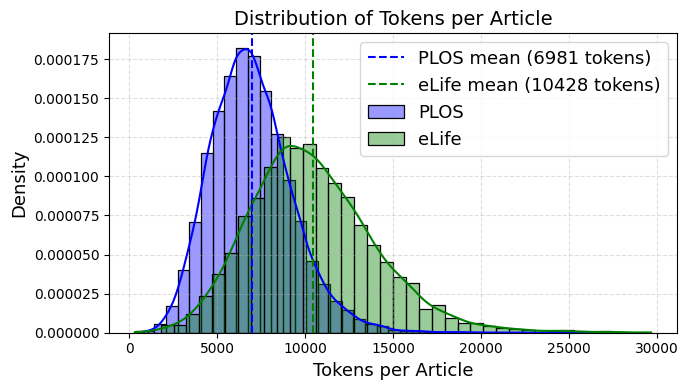

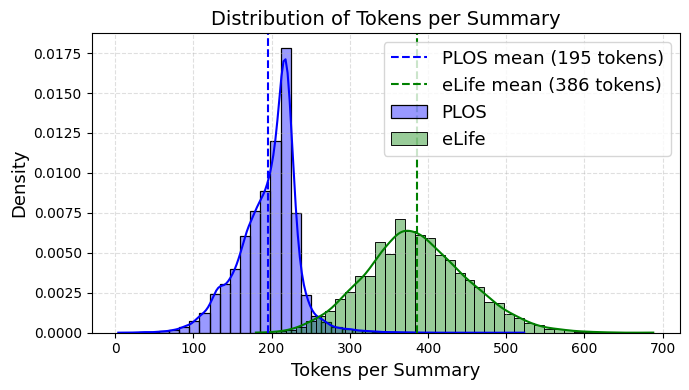

In [ ]:
def compare_length_distributions(plos_df, elife_df, save_dir=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os

    features = {
        "num_tokens_article_len": "Tokens per Article",
        "num_tokens_summary_len": "Tokens per Summary"
    }

    for feat, label in features.items():
        plt.figure(figsize=(7, 4))
        sns.histplot(plos_df[feat], bins=40, kde=True, stat="density", color="blue", label="PLOS", alpha=0.4)
        sns.histplot(elife_df[feat], bins=40, kde=True, stat="density", color="green", label="eLife", alpha=0.4)

        plos_mean = plos_df[feat].mean()
        elife_mean = elife_df[feat].mean()

        # Add vertical mean lines with labels
        plt.axvline(plos_mean, color="blue", linestyle="--", label=f"PLOS mean ({int(plos_mean)} tokens)")
        plt.axvline(elife_mean, color="green", linestyle="--", label=f"eLife mean ({int(elife_mean)} tokens)")



        plt.title(f"Distribution of {label}", fontsize=14)
        plt.xlabel(label, fontsize=13)
        plt.ylabel("Density", fontsize=13)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.4)

        # Manually order legend entries
        handles, labels = plt.gca().get_legend_handles_labels()
        order = ["PLOS", "eLife", f"PLOS mean ({int(plos_mean)} tokens)", f"eLife mean ({int(elife_mean)} tokens)"]
        ordered = sorted(zip(handles, labels), key=lambda x: order.index(x[1]))
        handles, labels = zip(*ordered)
        plt.legend(handles, labels, fontsize=13)
        plt.tight_layout()

        if save_dir:
            filename = f"{label.lower().replace(' ', '_')}_distribution.png"
            filepath = os.path.join(save_dir, filename)
            plt.savefig(filepath, dpi=300)

        plt.legend(fontsize=13)

        plt.show()


compare_length_distributions(plos_df['train'], elife_df['train'], save_dir=save_folder)



In [ ]:
# Saving to Drive
plos_df['train'].to_pickle('/content/drive/MyDrive/plos_train_tokenized.pkl')
elife_df['train'].to_pickle('/content/drive/MyDrive/elife_train_tokenized.pkl')

# # How to re-load
# from google.colab import drive
# drive.mount('/content/drive')

# import pandas as pd
# plos_df = {}  # If plos_df is not already defined
# elife_df = {}  # If elife_df is not already defined

# plos_df['train'] = pd.read_pickle('/content/drive/MyDrive/plos_train_tokenized.pkl')
# elife_df['train'] = pd.read_pickle('/content/drive/MyDrive/elife_train_tokenized.pkl')

##Get splits by sections

In [ ]:
def get_abstract(text):
    return text.split('\n')[0]  # Get text before first newline

def get_intro(text):
    return text.split('\n')[1]

def get_conclusion(text):
    return text.split('\n')[-1]

def word_tokenize_text(text):
    return word_tokenize(text)

def sentence_tokenize_text(text):
    return sent_tokenize(text)

for df in [plos_df_small['train'], elife_df_small['train']]:  # train split only
    # Extract abstract
    df['abstract'] = df['article'].apply(get_abstract)

    # Tokenize abstract
    df['abstract_tokens'] = df['abstract'].apply(word_tokenize_text)
    df['abstract_sentences'] = df['abstract'].apply(sentence_tokenize_text)

    # Calculate abstract length
    df['abstract_num_tokens'] = df['abstract_tokens'].apply(len)
    df['abstract_num_sentences'] = df['abstract_sentences'].apply(len)

    df['intro'] = df['article'].apply(get_intro)
    df['intro_tokens'] = df['intro'].apply(word_tokenize_text)
    df['intro_sentences'] = df['intro'].apply(sentence_tokenize_text)
    df['intro_num_tokens'] = df['intro_tokens'].apply(len)
    df['intro_num_sentences'] = df['intro_sentences'].apply(len)

    df['conc'] = df['article'].apply(get_conclusion)
    df['conc_tokens'] = df['conc'].apply(word_tokenize_text)
    df['conc_sentences'] = df['conc'].apply(sentence_tokenize_text)
    df['conc_num_tokens'] = df['conc_tokens'].apply(len)
    df['conc_num_sentences'] = df['conc_sentences'].apply(len)

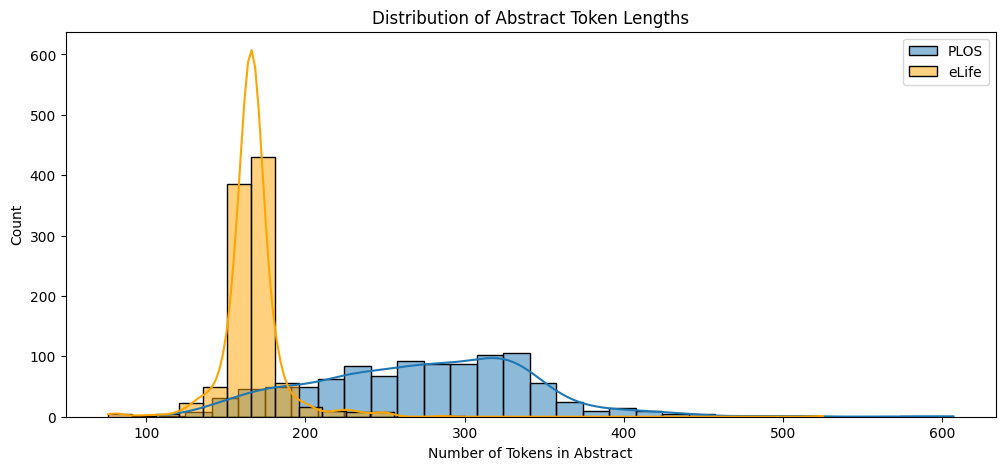

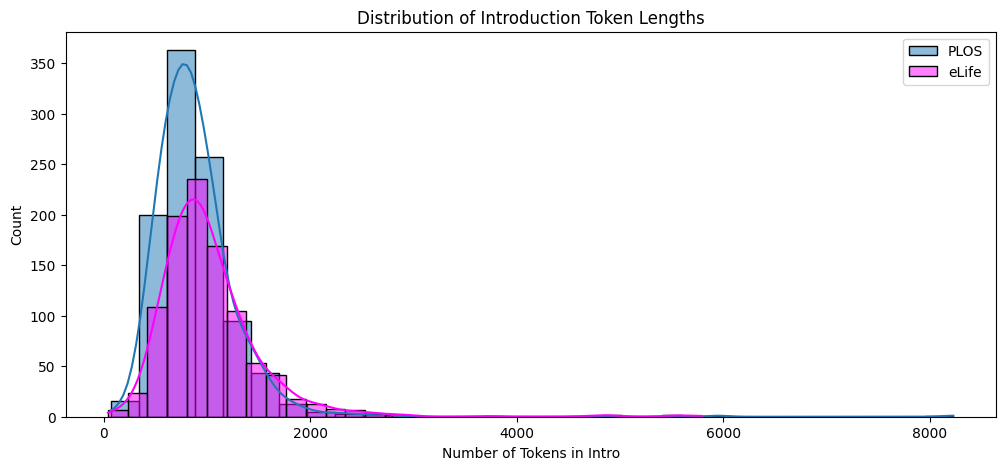

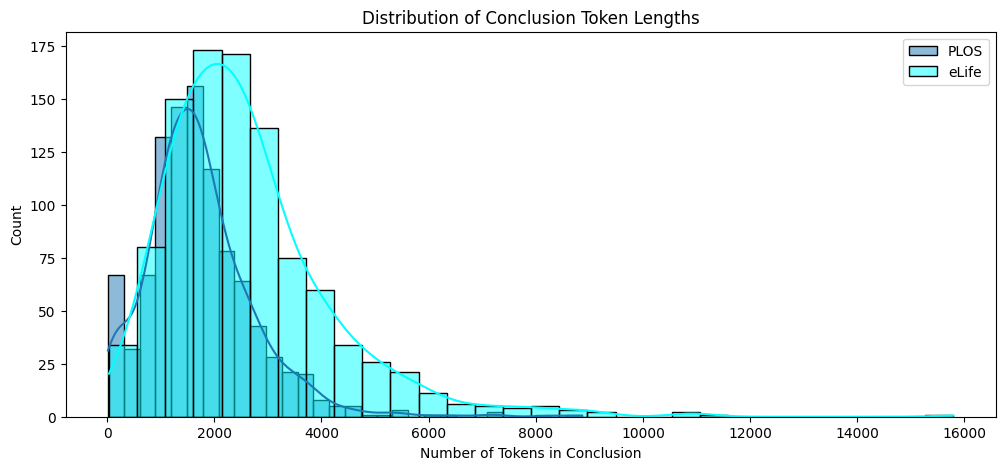

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.histplot(plos_df_small['train']['abstract_num_tokens'], bins=30, kde=True, label='PLOS')
sns.histplot(elife_df_small['train']['abstract_num_tokens'], bins=30, kde=True, label='eLife', color='orange')
plt.title("Distribution of Abstract Token Lengths")
plt.xlabel("Number of Tokens in Abstract")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(plos_df_small['train']['intro_num_tokens'], bins=30, kde=True, label='PLOS')
sns.histplot(elife_df_small['train']['intro_num_tokens'], bins=30, kde=True, label='eLife', color='magenta')
plt.title("Distribution of Introduction Token Lengths")
plt.xlabel("Number of Tokens in Intro")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(plos_df_small['train']['conc_num_tokens'], bins=30, kde=True, label='PLOS')
sns.histplot(elife_df_small['train']['conc_num_tokens'], bins=30, kde=True, label='eLife', color='cyan')
plt.title("Distribution of Conclusion Token Lengths")
plt.xlabel("Number of Tokens in Conclusion")
plt.legend()
plt.show()

## Compute Compression Features

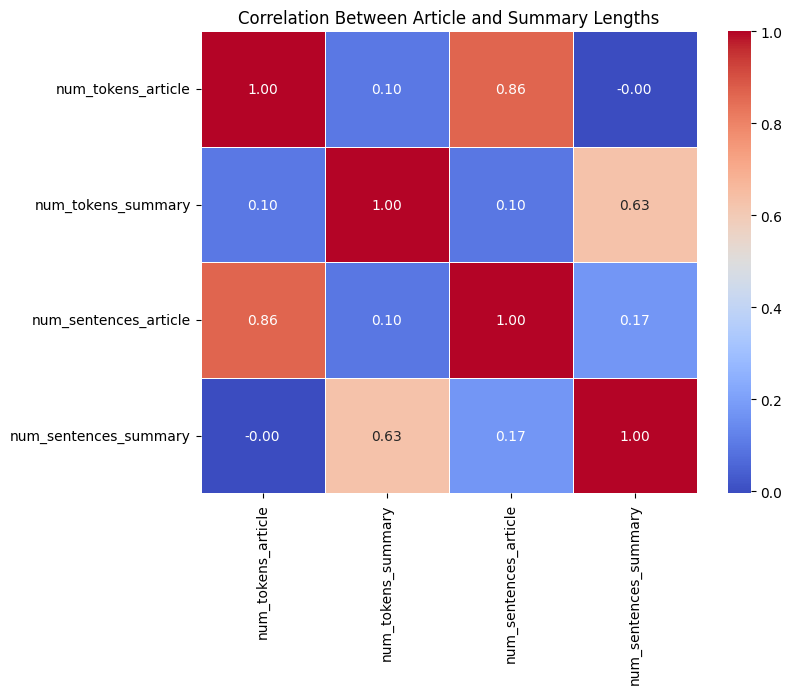

In [ ]:
# Length correlation heatmap
length_columns = ['num_tokens_article', 'num_tokens_summary', 'num_sentences_article', 'num_sentences_summary']
correlation_matrix = plos_df['train'][length_columns].corr()  # Use 'train' split, or whatever split you want

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Article and Summary Lengths")
plt.savefig(f"{save_folder}/art_sum_heatmap.png", dpi=300)
plt.show()

<ipython-input-16-023a0a960c27>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dataset', y='compression_ratio', data=mean_compression, palette=custom)


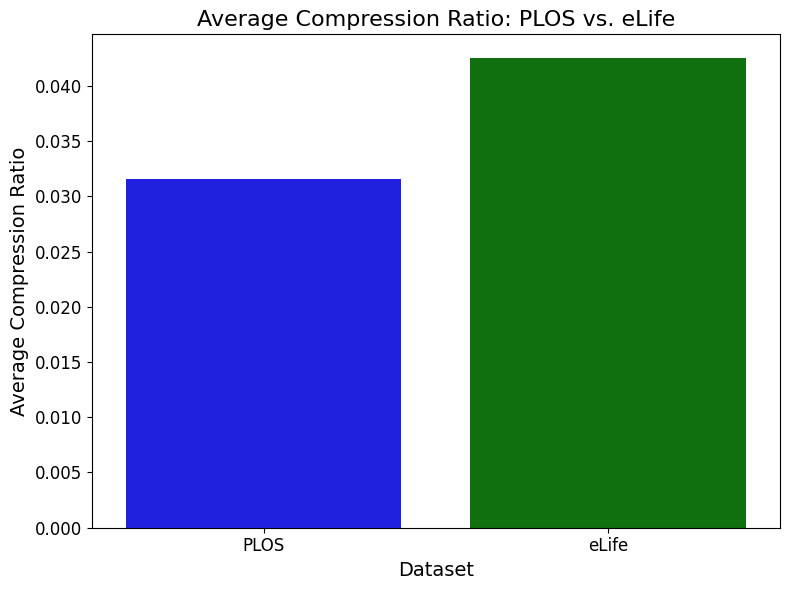

<ipython-input-16-023a0a960c27>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dataset', y='compression_ratio', data=combined_df, palette=custom)


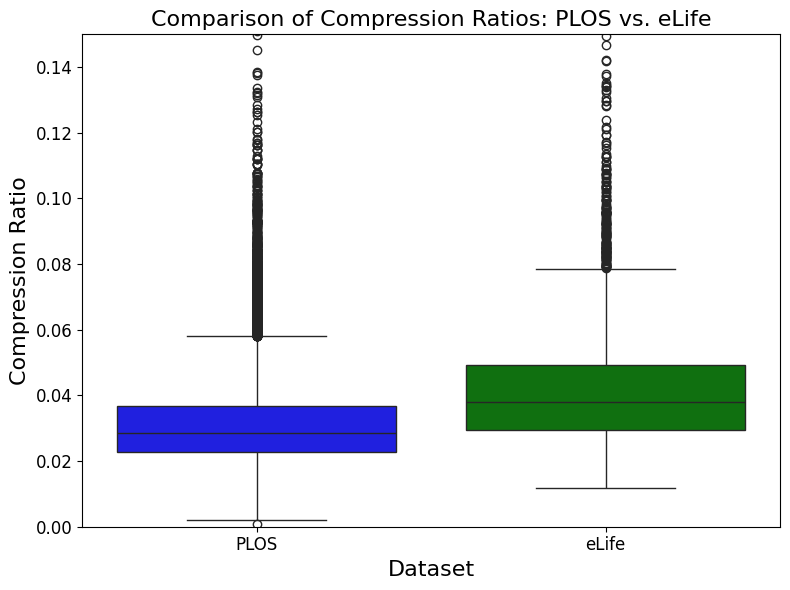

In [ ]:
# Compression ratio

custom = {"PLOS": "blue", "eLife": "green"}
plos_df['train']['compression_ratio'] = plos_df['train']['num_tokens_summary_len'] / plos_df['train']['num_tokens_article_len']
elife_df['train']['compression_ratio'] = elife_df['train']['num_tokens_summary_len'] / elife_df['train']['num_tokens_article_len']

plos_df['train']['dataset'] = 'PLOS'
elife_df['train']['dataset'] = 'eLife'

combined_df = pd.concat([plos_df['train'][['compression_ratio', 'dataset']], elife_df['train'][['compression_ratio', 'dataset']]])


mean_compression = combined_df.groupby('dataset')['compression_ratio'].mean().reset_index()

# Bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='dataset', y='compression_ratio', data=mean_compression, palette=custom)
plt.title("Average Compression Ratio: PLOS vs. eLife", fontsize=16)
plt.xlabel("Dataset", fontsize=14)
plt.ylabel("Average Compression Ratio", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"{save_folder}/avg_compression_ratio_bar.png", dpi=300)
plt.show()

# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='dataset', y='compression_ratio', data=combined_df, palette=custom)
plt.title("Comparison of Compression Ratios: PLOS vs. eLife", fontsize=16)
plt.xlabel("Dataset", fontsize=16)
plt.ylabel("Compression Ratio", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 0.15)
plt.tight_layout()
plt.savefig(f"{save_folder}/avg_compression_ratio_box.png", dpi=300)
plt.show()


##Calculating and visualizing readability scores for articles and summaries

In [ ]:
def compute_readability(df, colname):
    # Ensure the column exists before applying
    if colname in df.columns:
        df[f"{colname}_flesch_kincaid"] = df[colname].apply(textstat.flesch_kincaid_grade)
        df[f"{colname}_smog"] = df[colname].apply(textstat.smog_index)
        df[f"{colname}_coleman_liau"] = df[colname].apply(textstat.coleman_liau_index)
    else:
        print(f"Column '{colname}' not found in the DataFrame.")
    return df


plos_df_1 = compute_readability(plos_df['train'], "article")
plos_df_1 = compute_readability(plos_df['train'], "summary")

elife_df_1 = compute_readability(elife_df['train'], "article")
elife_df_1 = compute_readability(elife_df['train'], "summary")

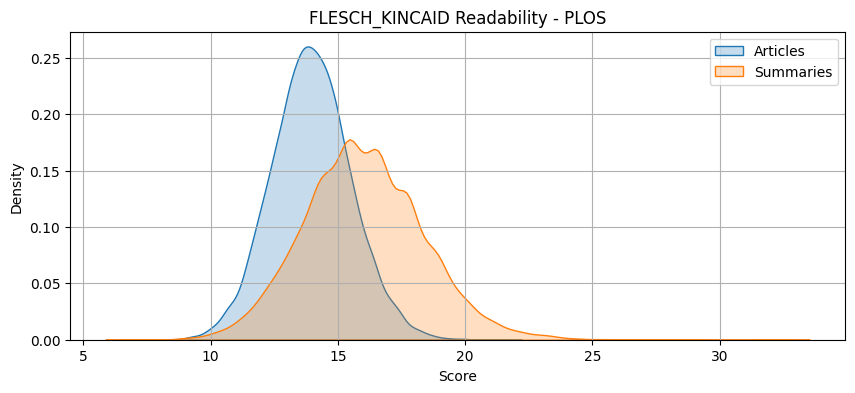

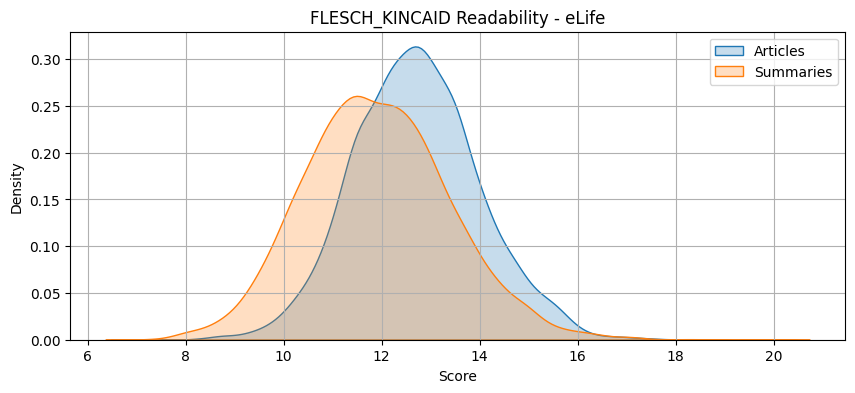

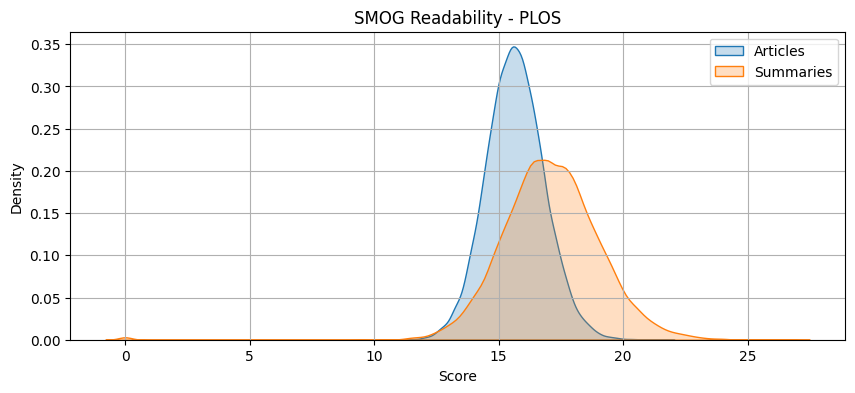

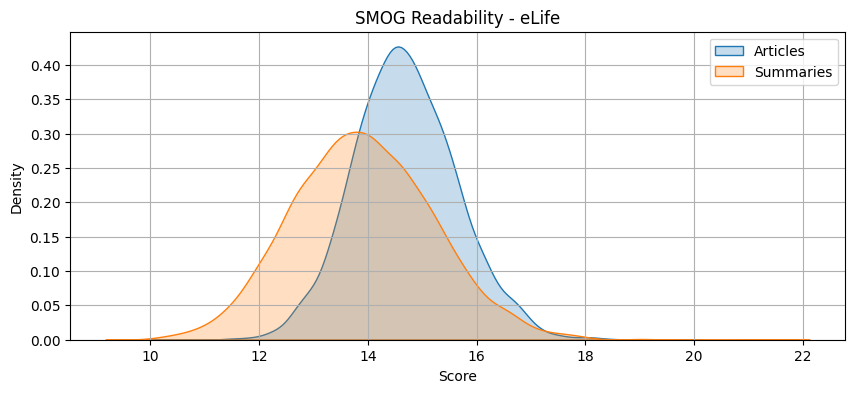

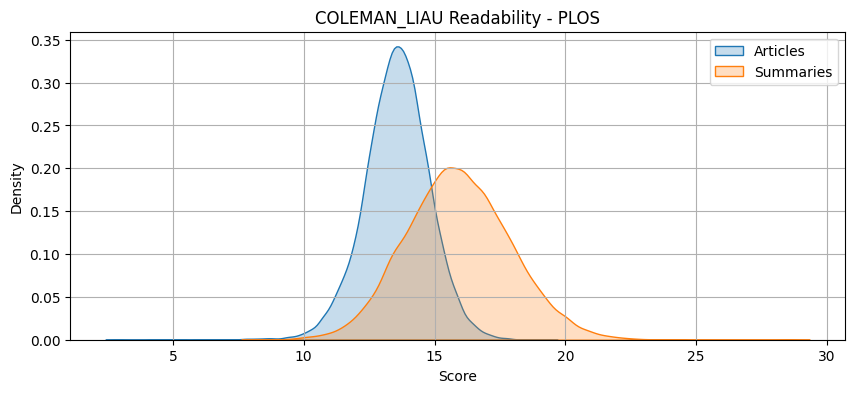

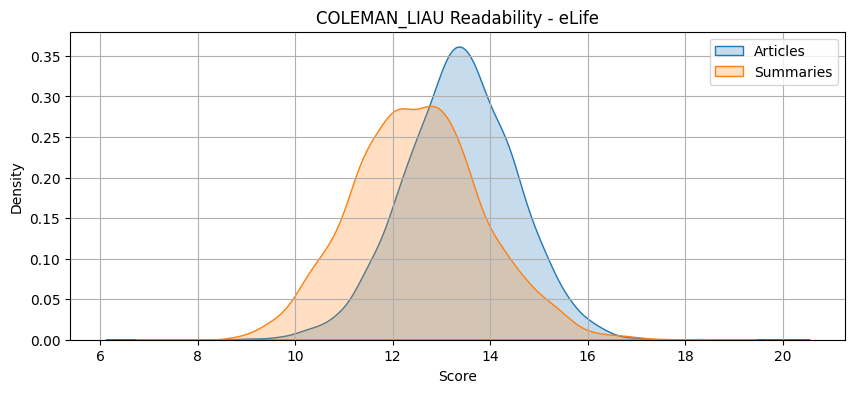

In [ ]:
def plot_readability_comparison(df, label, metric, save_dir=None):
    plt.figure(figsize=(10, 4))
    sns.kdeplot(df[f"article_{metric}"], label="Articles", fill=True)
    sns.kdeplot(df[f"summary_{metric}"], label="Summaries", fill=True)
    plt.title(f"{metric.upper()} Readability - {label}")
    plt.xlabel("Score")
    plt.legend()
    plt.grid(True)
    if save_dir:
            filename = f"{label}_{metric}.png"
            filepath = os.path.join(save_dir, filename)
            plt.savefig(filepath, dpi=300)
    plt.show()

for metric in ["flesch_kincaid", "smog", "coleman_liau"]:
    plot_readability_comparison(plos_df_1, "PLOS", metric, save_dir=save_folder)
    plot_readability_comparison(elife_df_1, "eLife", metric, save_dir=save_folder)


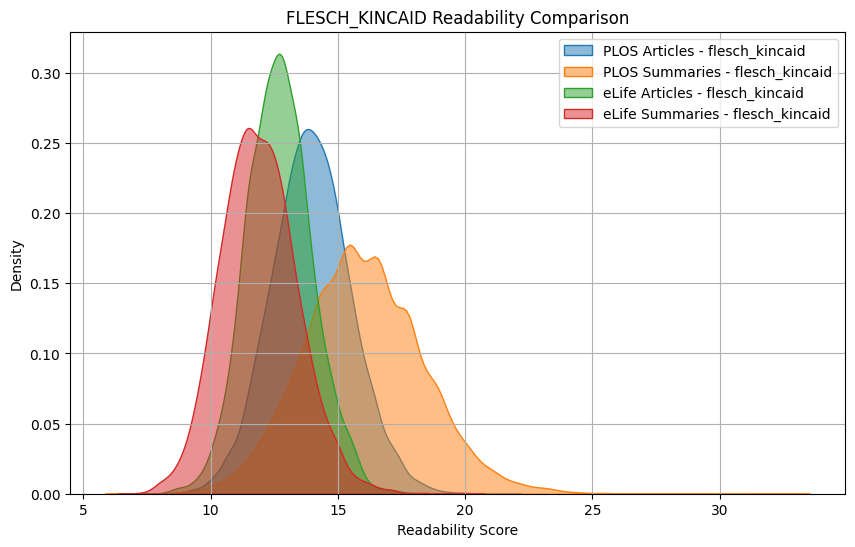

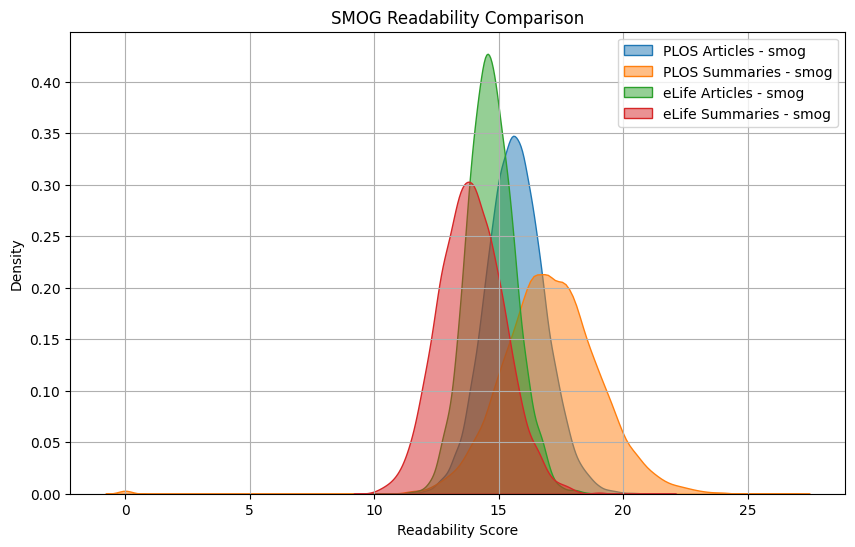

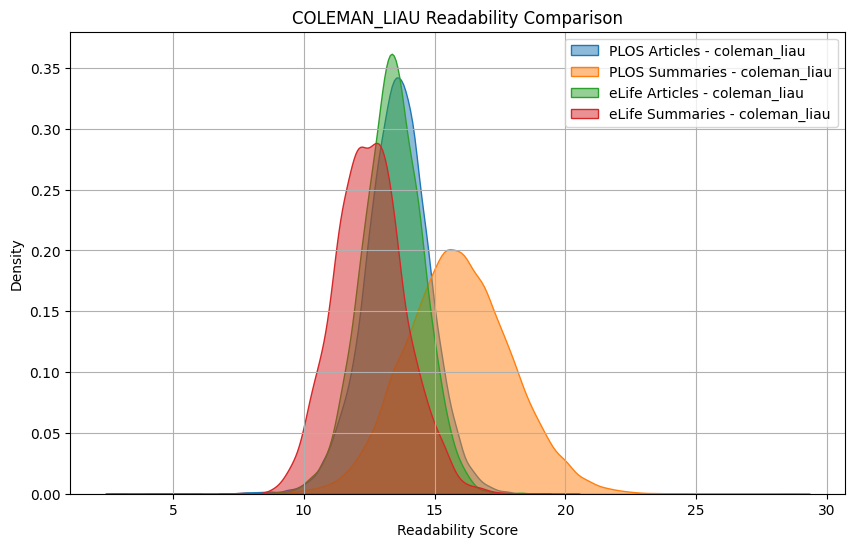

In [ ]:
def plot_readability_comparison(df_plos, df_elife, metric, save_dir=None):
    plt.figure(figsize=(10, 6))

    # Plot for PLOS
    sns.kdeplot(df_plos[f"article_{metric}"], label=f"PLOS Articles - {metric}", fill=True, alpha=0.5)
    sns.kdeplot(df_plos[f"summary_{metric}"], label=f"PLOS Summaries - {metric}", fill=True, alpha=0.5)

    # Plot for eLife
    sns.kdeplot(df_elife[f"article_{metric}"], label=f"eLife Articles - {metric}", fill=True, alpha=0.5)
    sns.kdeplot(df_elife[f"summary_{metric}"], label=f"eLife Summaries - {metric}", fill=True, alpha=0.5)

    plt.title(f"{metric.upper()} Readability Comparison")
    plt.xlabel("Readability Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    if save_dir:
            filename = f"read_comp_{metric}.png"
            filepath = os.path.join(save_dir, filename)
            plt.savefig(filepath, dpi=300)
    plt.show()

# List of readability metrics to compare
metrics = ["flesch_kincaid", "smog", "coleman_liau"]

# Plot for each metric
for metric in metrics:
    plot_readability_comparison(plos_df_1, elife_df_1, metric, save_dir=save_folder)


## Other features

In [ ]:
def vocab_overlap(df):
    overlaps = []

    for art_tokens, summ_tokens in zip(df['num_tokens_article'], df['num_tokens_summary']):
        art_set = set(art_tokens)
        summ_set = set(summ_tokens)

        if len(summ_set) > 0:
            overlap = len(art_set & summ_set) / len(summ_set)
            overlaps.append(overlap)

    plt.figure(figsize=(8, 4))
    sns.histplot(overlaps, bins=20, kde=True)
    plt.title("Vocabulary Overlap (% shared words in summaries)")
    plt.xlabel("Overlap Ratio")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

    print(f"Mean Overlap: {sum(overlaps)/len(overlaps):.2f}")

vocab_overlap(plos_df['train'])
vocab_overlap(elife_df['train'])